In [1]:
import pandas as pd
import numpy as np
from src.process import RFMData
from src.models import BgNbd, NewBgNbd

## 导入数据

In [2]:
df = pd.read_csv('data/data.csv', usecols=['会员姓名', '电话', '会员生日', '性别', '年龄', '消费时间', '商品名称', '单位', '商品数量', '实收金额', 'id'])
rfm = RFMData(df)
data = rfm.get_features(rfm.train_data)

## 建立bg/nbd模型及改进模型

In [3]:
from lifetimes import BetaGeoFitter
bg = BetaGeoFitter()
bg.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 39709 subjects, a: 0.08, alpha: 10.27, b: 0.36, r: 2.45>

In [4]:
model = BgNbd(data['frequency'], data['recency'], data['T'], np.ones(4))
model.fit()
print(model.params)

[ 2.45322621 10.26660243  0.07629921  0.35526958]


In [5]:
model_1 = NewBgNbd(data['frequency'], data['recency'], data['T'], data['preference'], 0, init_params=np.ones(5))
model_1.fit()
print(model_1.params)

[ 2.45322583 24.59425704  0.0762992   0.35526947  1.74559514]


In [6]:
model_2 = NewBgNbd(data['frequency'], data['recency'], data['T'], data['preference'], 1, init_params=np.ones(6))
model_2.fit()
print(model_2.params)

[ 2.45322587 10.2666007   0.01447765  0.5269893   3.32099481 -0.78786708]


## 根据参数估计画图

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',**{'family':'sans-serif','sans-serif':['simsun']})
plt.rcParams['figure.dpi']=150
plt.style.use('bmh')

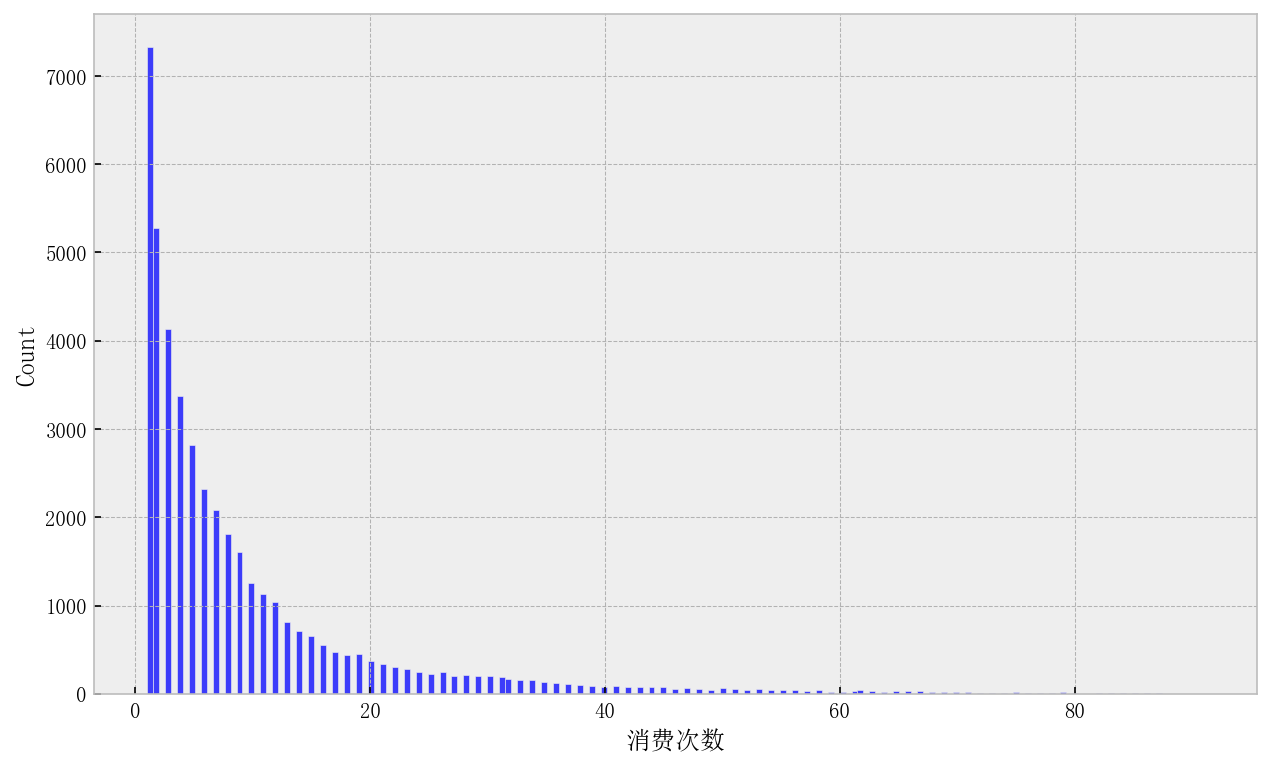

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm.df.groupby('id')['消费时间'].count())
plt.xlabel('消费次数')
plt.show()

In [9]:
list_date = pd.date_range('2022-11-01','2022-11-30',freq='D')
bgf_score = []
bgf_1_score = []
bgf_2_score = []
true_score = []
for i in range(1, len(list_date) + 1):
    true_score.append(rfm.test_data[rfm.test_data['消费时间'] <= list_date[i - 1]].groupby('id')['消费时间'].nunique().sum())
#     bgf_score.append(data.apply(lambda x: model.calculate_conditional_expectation(i, x['frequency'], x['recency'], x['T']), axis=1).sum())
#     bgf_1_score.append(data.apply(lambda x: model_1.calculate_conditional_expectation(i, x['frequency'], x['recency'], x['T']), axis=1).sum())
#     bgf_2_score.append(data.apply(lambda x: model_2.calculate_conditional_expectation(i, x['frequency'], x['recency'], x['T']), axis=1).sum())
    bgf_score.append(model.predict(i, data['frequency'], data['recency'], data['T']).sum())
    bgf_1_score.append(model_1.predict(i, data['frequency'], data['recency'], data['T']).sum())
    bgf_2_score.append(model_2.predict(i, data['frequency'], data['recency'], data['T']).sum())

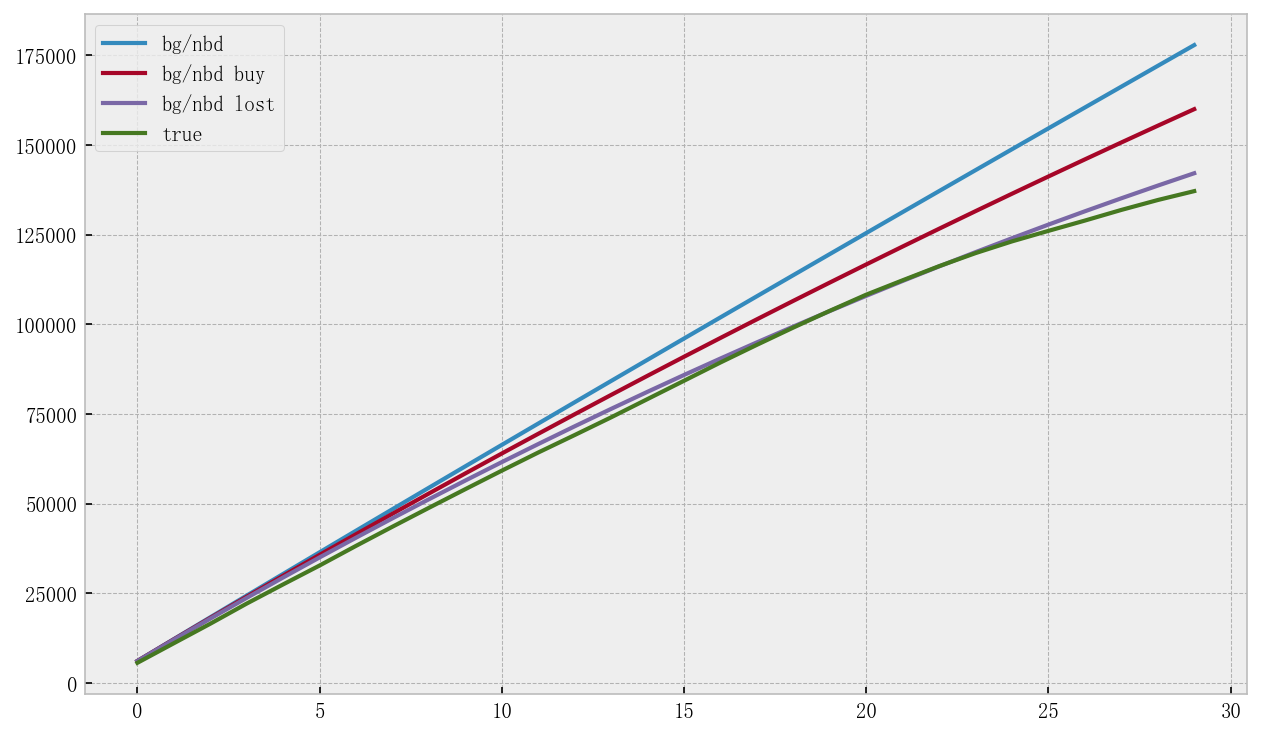

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(bgf_score, label='bg/nbd')
plt.plot(bgf_1_score, label='bg/nbd buy')
plt.plot(bgf_2_score, label='bg/nbd lost')
plt.plot(true_score, label='true')
plt.legend()
plt.show()

In [11]:
bgf_df = pd.DataFrame()
bgf_df['id'] = data['id']
bgf_df['model'] = data.apply(lambda x: model.calculate_conditional_expectation(30, x['frequency'], x['recency'], x['T']), axis=1)
bgf_df['model_1'] = data.apply(lambda x: model_1.calculate_conditional_expectation(30, x['frequency'], x['recency'], x['T']), axis=1)
bgf_df['model_2'] = data.apply(lambda x: model_2.calculate_conditional_expectation(30, x['frequency'], x['recency'], x['T']), axis=1)

true_df = rfm.test_data[rfm.test_data['消费时间'] <= list_date[-1]].groupby('id')['消费时间'].nunique().reset_index()
true_df.columns = ['id', 'true']

bgf_df = pd.merge(bgf_df, true_df, on='id')
bgf_df[bgf_df.columns[bgf_df.columns.str.startswith('m')]] = np.ceil(np.clip(bgf_df[bgf_df.columns[bgf_df.columns.str.startswith('m')]], 1, 999))

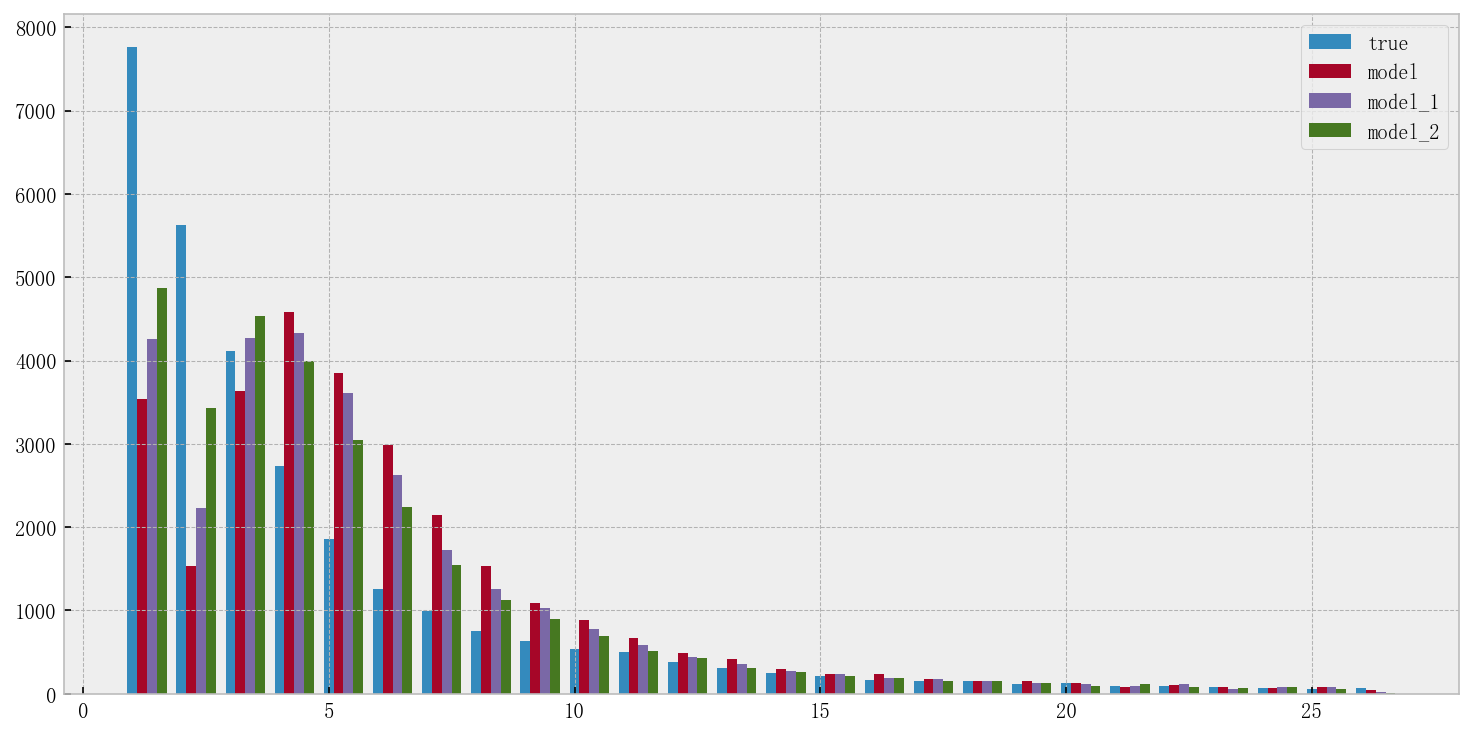

In [12]:
count_df = pd.concat([bgf_df['true'].value_counts(), bgf_df['model'].value_counts(), bgf_df['model_1'].value_counts(), bgf_df['model_2'].value_counts()], axis=1)
count_df = count_df.dropna()
plt.figure(figsize=(12, 6))
bar_width= 0.2
for idx, col in enumerate(count_df.columns):
    plt.bar(count_df.index + idx * bar_width, count_df[col], bar_width, label=col)
plt.legend(loc='upper right')
plt.show()

In [13]:
for col in ['model', 'model_1', 'model_2']:
    count_df[col + '_loss'] = (count_df['true'] - count_df[col]) / count_df['true'] * 100
    count_df[col + '_loss'] = count_df[col + '_loss'].apply(lambda x: str(round(x, 2)) + '%')

In [14]:
count_df

,true,model,model_1,model_2,model_loss,model_1_loss,model_2_loss
1.0,7770,3544.0,4255.0,4872.0,54.39%,45.24%,37.3%
2.0,5626,1532.0,2234.0,3434.0,72.77%,60.29%,38.96%
3.0,4112,3630.0,4267.0,4539.0,11.72%,-3.77%,-10.38%
4.0,2730,4584.0,4332.0,4000.0,-67.91%,-58.68%,-46.52%
5.0,1855,3853.0,3611.0,3042.0,-107.71%,-94.66%,-63.99%
6.0,1262,2982.0,2626.0,2243.0,-136.29%,-108.08%,-77.73%
7.0,998,2141.0,1725.0,1549.0,-114.53%,-72.85%,-55.21%
8.0,747,1534.0,1252.0,1123.0,-105.35%,-67.6%,-50.33%
9.0,631,1094.0,1028.0,892.0,-73.38%,-62.92%,-41.36%
10.0,541,884.0,775.0,689.0,-63.4%,-43.25%,-27.36%


In [15]:
print('rss:')
for col in ['model', 'model_1', 'model_2']:
    value = ((count_df['true'] - count_df[col]) ** 2).sum()
    print('{}: {}'.format(col, value))

rss:
model: 47562270.0
model_1: 32412908.0
model_2: 17913982.0


# Gamma-Gamma

In [16]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter()
ggf.fit(data['frequency'], data['money'])

<lifetimes.GammaGammaFitter: fitted with 39709 subjects, p: 1.52, q: 1.33, v: 78.73>

In [17]:
gg_pred = ggf.conditional_expected_average_profit(data['frequency'], data['money'])
gg_pred

0        237.144253
1         30.756308
2         73.697306
3        210.947526
4        327.491811
            ...    
39704    106.508597
39705    145.058278
39706    393.199127
39707    206.172651
39708     51.737055
Length: 39709, dtype: float64

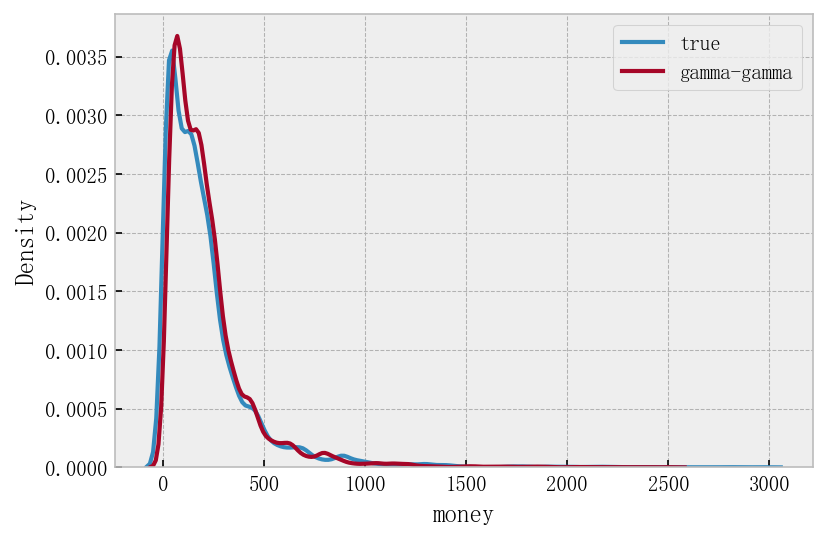

In [18]:
sns.kdeplot(data['money'], label='true')
sns.kdeplot(gg_pred, label='gamma-gamma')
plt.legend()
plt.show()

## 其他商品加入卷烟购买数量的改进模型

In [1]:
import pandas as pd
import numpy as np
from src.process import RFMData
from src.models import BgNbd, NewBgNbd

df1 = pd.read_csv('data/wine_data.csv', usecols=['会员姓名', '电话', '会员生日', '性别', '年龄', '消费时间', '商品名称', '单位', '商品数量', '实收金额', 'id'])
df2 = pd.read_csv('data/other_data.csv', usecols=['会员姓名', '电话', '会员生日', '性别', '年龄', '消费时间', '商品名称', '单位', '商品数量', '实收金额', 'id'])
df = pd.concat([df1, df2], ignore_index=True)
rfm = RFMData(df)
data = rfm.get_features(rfm.train_data)

In [15]:
model = BgNbd(data['frequency'], data['recency'], data['T'], np.ones(4))
model.fit()
print(model.params)

[2.07330333 7.50712834 0.18875935 0.39773957]


In [2]:
model_1 = NewBgNbd(data['frequency'], data['recency'], data['T'], data['preference'], 0, init_params=np.ones(5))
model_1.fit()
print(model_1.params)

[ 2.07330321 41.82302835  0.18875934  0.3977395   2.65336872]


In [3]:
model_2 = NewBgNbd(data['frequency'], data['recency'], data['T'], data['preference'], 1, init_params=np.ones(6))
model_2.fit()
print(model_2.params)

[ 2.0733032   7.5071274   0.05177599  1.90321158  1.99829241 -2.41841206]


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',**{'family':'sans-serif','sans-serif':['simsun']})
plt.rcParams['figure.dpi']=150
plt.style.use('bmh')

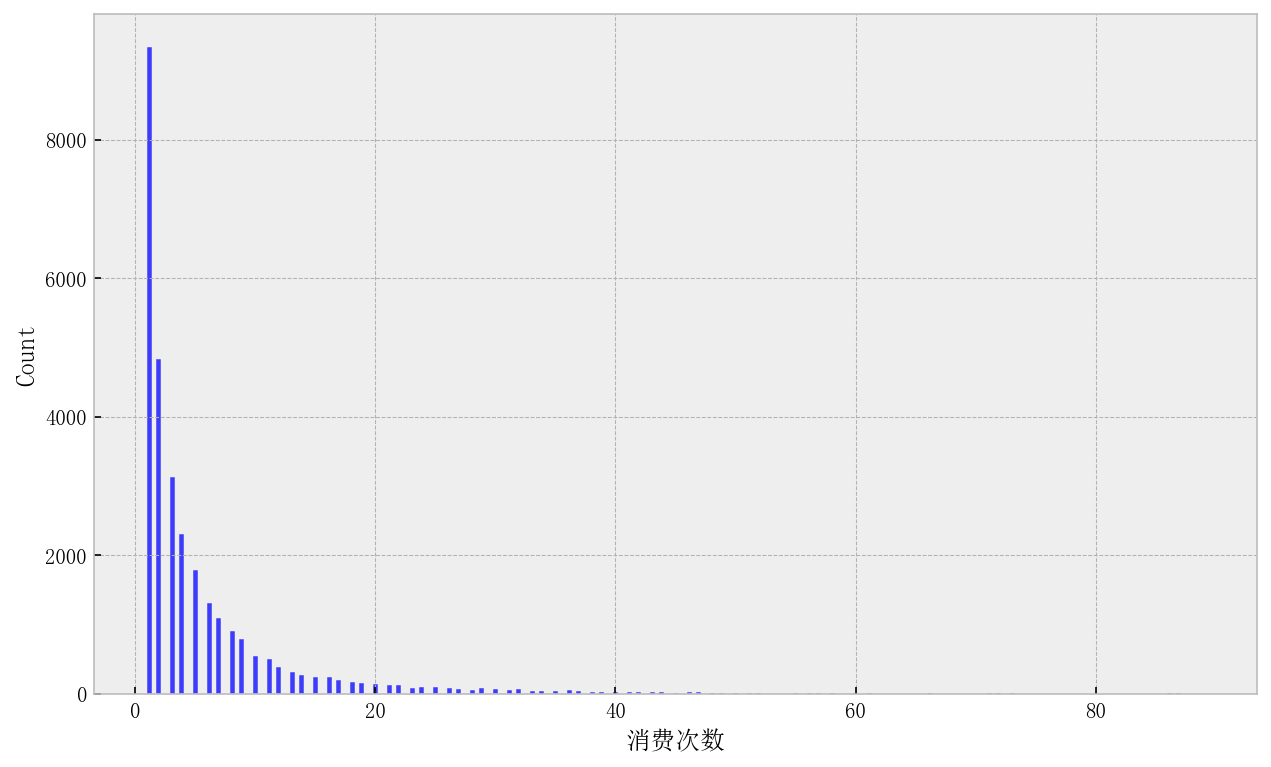

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm.df.groupby('id')['消费时间'].count())
plt.xlabel('消费次数')
plt.show()

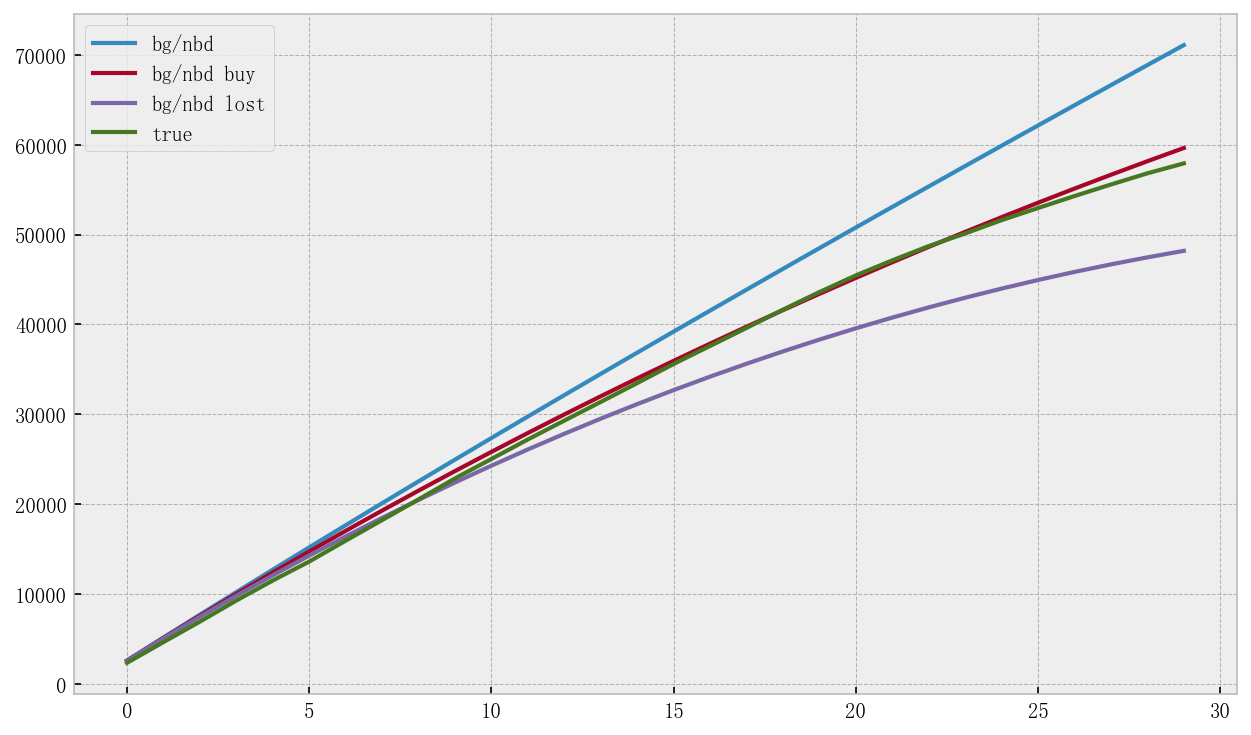

In [16]:
list_date = pd.date_range('2022-11-01','2022-11-30',freq='D')
bgf_score = []
bgf_1_score = []
bgf_2_score = []
true_score = []
for i in range(1, len(list_date) + 1):
    true_score.append(rfm.test_data[rfm.test_data['消费时间'] <= list_date[i - 1]].groupby('id')['消费时间'].nunique().sum())
    bgf_score.append(model.predict(i, data['frequency'], data['recency'], data['T']).sum())
    bgf_1_score.append(model_1.predict(i, data['frequency'], data['recency'], data['T']).sum())
    bgf_2_score.append(model_2.predict(i, data['frequency'], data['recency'], data['T']).sum())
    
plt.figure(figsize=(10, 6))
plt.plot(bgf_score, label='bg/nbd')
plt.plot(bgf_1_score, label='bg/nbd buy')
plt.plot(bgf_2_score, label='bg/nbd lost')
plt.plot(true_score, label='true')
plt.legend()
plt.show()

In [23]:
bgf_df = pd.DataFrame()
bgf_df['id'] = data['id']
bgf_df['model'] = data.apply(lambda x: model.calculate_conditional_expectation(30, x['frequency'], x['recency'], x['T']), axis=1)
bgf_df['model_2'] = data.apply(lambda x: model_1.calculate_conditional_expectation(30, x['frequency'], x['recency'], x['T']), axis=1)
bgf_df['model_1'] = data.apply(lambda x: model_2.calculate_conditional_expectation(30, x['frequency'], x['recency'], x['T']), axis=1)

true_df = rfm.test_data[rfm.test_data['消费时间'] <= list_date[-1]].groupby('id')['消费时间'].nunique().reset_index()
true_df.columns = ['id', 'true']

bgf_df = pd.merge(bgf_df, true_df, on='id')
bgf_df[bgf_df.columns[bgf_df.columns.str.startswith('m')]] = np.ceil(np.clip(bgf_df[bgf_df.columns[bgf_df.columns.str.startswith('m')]], 1, 999))

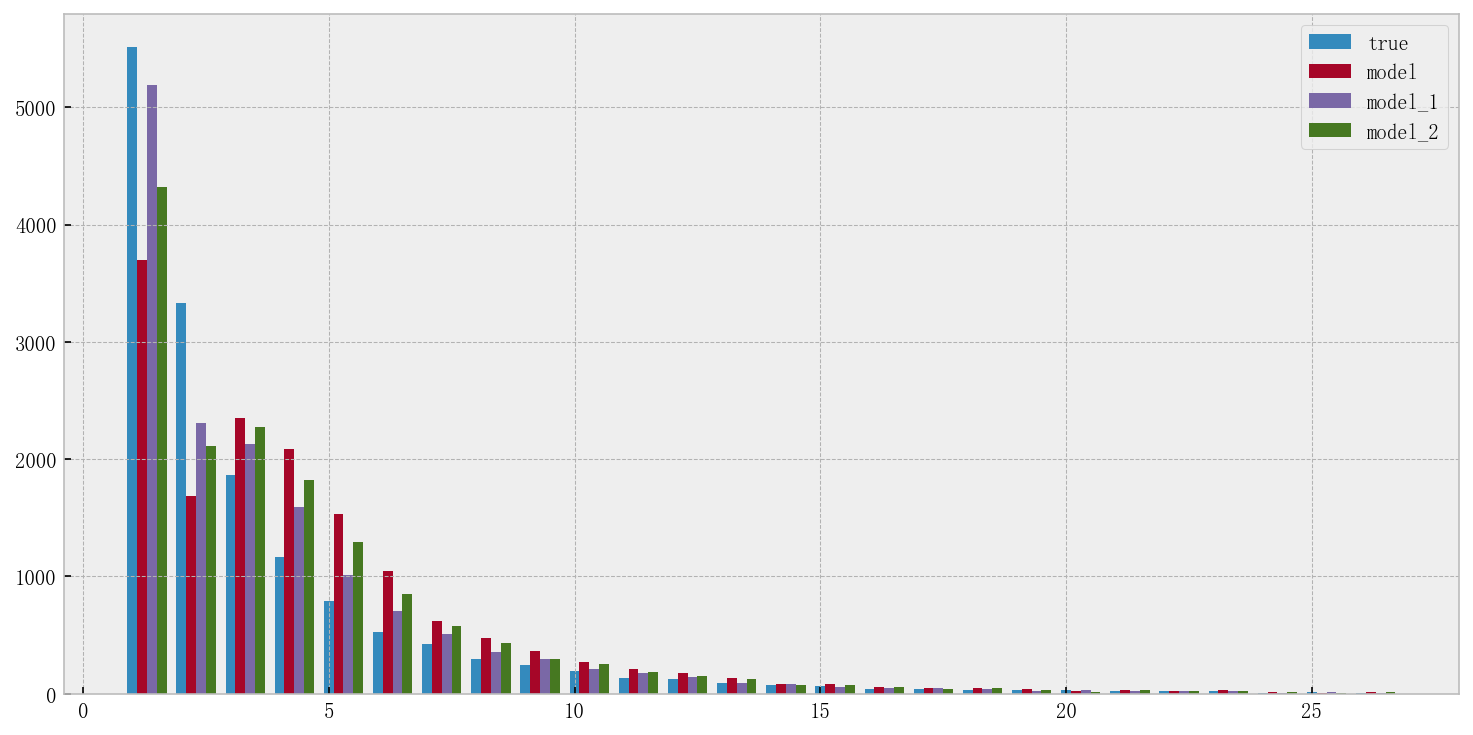

In [24]:
count_df = pd.concat([bgf_df['true'].value_counts(), bgf_df['model'].value_counts(), bgf_df['model_1'].value_counts(), bgf_df['model_2'].value_counts()], axis=1)
count_df = count_df.dropna()
plt.figure(figsize=(12, 6))
bar_width= 0.2
for idx, col in enumerate(count_df.columns):
    plt.bar(count_df.index + idx * bar_width, count_df[col], bar_width, label=col)
plt.legend(loc='upper right')
plt.show()

In [25]:
for col in ['model', 'model_1', 'model_2']:
    count_df[col + '_loss'] = (count_df['true'] - count_df[col]) / count_df['true'] * 100
    count_df[col + '_loss'] = count_df[col + '_loss'].apply(lambda x: str(round(x, 2)) + '%')
count_df

,true,model,model_1,model_2,model_loss,model_1_loss,model_2_loss
1,5518,3694.0,5194.0,4317.0,33.06%,5.87%,21.77%
2,3332,1684.0,2311.0,2109.0,49.46%,30.64%,36.7%
3,1864,2350.0,2129.0,2271.0,-26.07%,-14.22%,-21.83%
4,1165,2085.0,1592.0,1819.0,-78.97%,-36.65%,-56.14%
5,794,1529.0,1008.0,1297.0,-92.57%,-26.95%,-63.35%
6,529,1047.0,706.0,847.0,-97.92%,-33.46%,-60.11%
7,425,622.0,508.0,579.0,-46.35%,-19.53%,-36.24%
8,298,479.0,358.0,429.0,-60.74%,-20.13%,-43.96%
9,242,362.0,298.0,300.0,-49.59%,-23.14%,-23.97%
10,190,267.0,214.0,257.0,-40.53%,-12.63%,-35.26%


In [26]:
print('rss:')
for col in ['model', 'model_1', 'model_2']:
    value = ((count_df['true'] - count_df[col]) ** 2).sum()
    print('{}: {}'.format(col, value))

rss:
model: 8038319.0
model_1: 1493757.0
model_2: 3940322.0


In [27]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter()
ggf.fit(data['frequency'], data['money'])

<lifetimes.GammaGammaFitter: fitted with 25449 subjects, p: 2.41, q: 0.72, v: 8.23>

In [28]:
gg_pred = ggf.conditional_expected_average_profit(data['frequency'], data['money'])
gg_pred

0          20.119795
1         139.678570
2          26.154840
3          17.919958
4           8.444819
5          22.929902
6          39.932135
7          25.889199
8          18.631966
9          92.299874
10        430.223500
11         33.395292
12         81.942151
13         21.596611
14         10.919249
15         37.665171
16         20.618407
17         24.063384
18         27.217406
19        179.222565
20        173.902979
21        434.383944
22       1546.461366
23         64.959823
24        143.568319
25         30.936384
26         47.547780
27         20.354435
28        168.015625
29        136.278123
            ...     
25419      43.795707
25420      34.060158
25421      11.599262
25422      51.390769
25423      43.333163
25424     530.729932
25425       8.708620
25426      15.408840
25427      24.063384
25428      14.282307
25429      57.500520
25430      36.531688
25431     253.113165
25432     553.399576
25433     322.169205
25434    1165.906029
25435      17

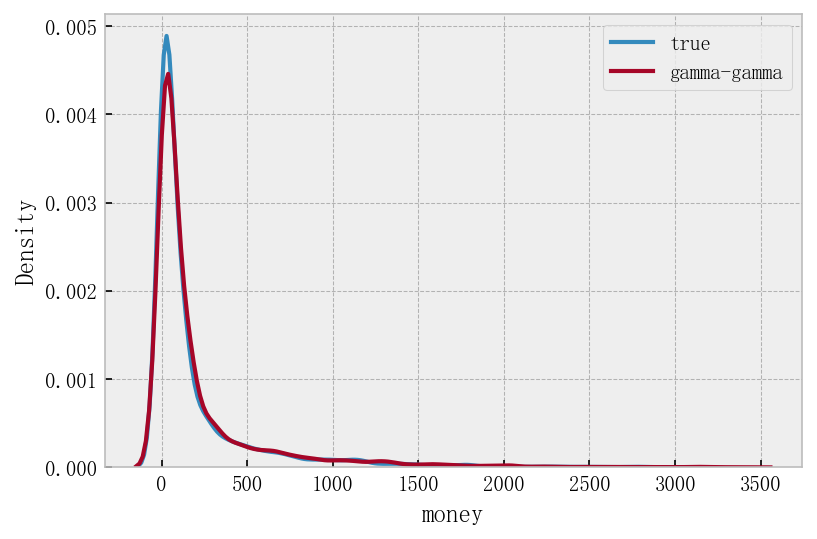

In [29]:
sns.kdeplot(data['money'], label='true')
sns.kdeplot(gg_pred, label='gamma-gamma')
plt.legend()
plt.show()